# Visualizing Noise Functions for Procedural Terrain Generation

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import numpy as np
import random
import math
import plotly.graph_objects as go
import plotly.offline as pyo
from IPython.display import clear_output
import sys

def vectors(x, y, res_size):
    v1 = np.array([x, y])
    v2 = np.array([x, y-res_size])
    v3 = np.array([x-res_size, y])
    v4 = np.array([x-res_size, y-res_size])
    return (v1, v2, v3, v4)

def interpolate(t, x, y):
    return x + t*(y-x)

def dot(v1, v2):
    return v1[0]*v2[0] + v1[1]*v2[1]

def fade(val):
    # return val * val * (3 - 2 * val)
    return ((6*val - 15)*val + 10)*val*val*val

# def make_unit_vectors(width, res, seed, offset=0):
#     size = res + 1 + offset//res
#     unit_vectors = [[(0, 0) for _ in range(size)] for _ in range(size)]
#     for i in range(size):
#         for j in range(size):
#             # random.seed(int(str((i*(width//res)))+str(j*(width//res)))*seed)
#             # x = random.random() * 2 * math.pi
#             # unit_vectors[i][j] = np.array([math.cos(x), math.sin(x)])
#             unit_vectors[i][j] = get_unit_vector(i, j, seed)

#     return np.array(unit_vectors)

def get_unit_vector(x, y, seed):
    random.seed(int(str(x)+str(y))*seed)
    x = random.random() * 2 * math.pi
    return np.array([math.cos(x), math.sin(x)])

def make_unit_vectors(x, y, res_size, seed):
    xoff = x % res_size
    yoff = y % res_size
    x1 = x - xoff
    x2 = x + res_size - xoff
    y1 = y - yoff
    y2 = y + res_size - yoff
    return (get_unit_vector(x1, y1, seed), get_unit_vector(x1, y2, seed), get_unit_vector(x2, y1, seed), get_unit_vector(x2, y2, seed))
    

def norm(h, a, b):
    '''
    return: h values normalized in the range [a,b]
    '''
    if a==b:
        return np.full(h.shape, a)

    return ((h - np.min(h)) / (np.max(h) - np.min(h)) * abs(b-a)) - a

def norm_zero(h):
    ''' 
    return: values in an array normalized in the range [0, 1]
    '''
    return (h - np.min(h)) / (np.max(h) - np.min(h))

def perlin(x, y, res_size, seed):
    # unit_vectors = make_unit_vectors(width, res, seed, offset)
    # res_size = width / res
    # z = np.zeros((width, width))
    # for i in range(offset, width+offset):
    #     for j in range(offset, width+offset):
    v_x = x % res_size
    v_y = y % res_size

    vs = vectors(v_x, v_y, res_size)
    uv = make_unit_vectors(x, y, res_size, seed)

    dotTopLeft = dot(vs[0], uv[0])
    dotTopRight = dot(vs[1], uv[1])
    dotBottomLeft = dot(vs[2], uv[2])
    dotBottomRight = dot(vs[3], uv[3])

    x_t =  v_x / res_size
    y_t =  v_y / res_size

    x_t = fade(x_t)
    y_t = fade(y_t)

    z = interpolate(x_t, interpolate(y_t, dotTopLeft, dotTopRight), interpolate(y_t, dotBottomLeft, dotBottomRight))

    return z
    #return ((z - np.min(z)) / (np.max(z) - np.min(z)) * 2) - 1

def make_perlin_heightmap(width, resolution, x_offset=0, y_offset=0, seed=None):

    if seed is None:
        seed = random.randint(0, sys.maxsize)

    hmap = np.zeros((width, width))

    for x in range(width):
        for y in range(width):
            # Offsets are flipped because of the way arrays are
            hmap[x][y] = perlin(x+y_offset, y+x_offset, width//resolution, seed)

    return hmap

def fractal_noise(width, _res, functions=None, comb_func=None, persistence=0.5, seed=None, x_offset=0, y_offset=0):
    h = np.zeros((width, width))

    scale = 1

    if seed is not None:
        random.seed(seed)

    for r in range(len(_res)):
        res = _res[r]
        # print("Current scale", scale_current)
        print("Resolution", res, "starting.")
        
        z = make_perlin_heightmap(width, res, x_offset, y_offset, seed=seed)

        if functions is not None:
            cur_func = functions[r]
            if cur_func: z = cur_func(z)

        if r==0:
            h += z
        else:
            h = comb_func(h, z, scale)

        clear_output(wait=True)
        print("Resolution", res, "finished.")
        scale = scale*persistence

    return norm_zero(h)

# Example of fully random noise

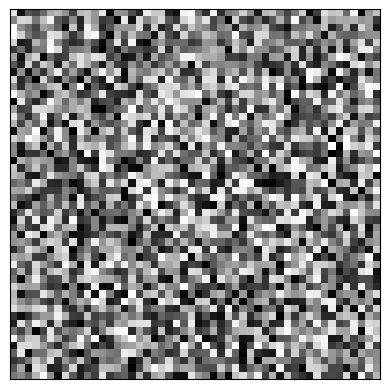

In [2]:
noise = np.random.rand(50, 50)

plt.imshow(noise, cmap='grey')
plt.yticks([])
plt.xticks([])
plt.show()

# Example of Basic Perlin Noise

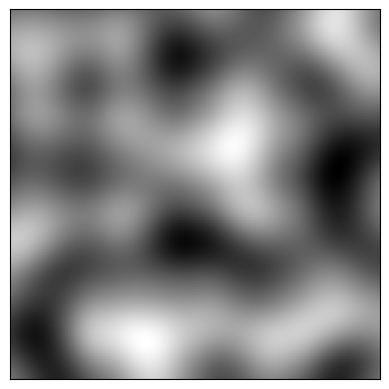

In [3]:
hmap = make_perlin_heightmap(128, 4, seed=10, y_offset=128)

# Uncomment to make ridged perlin noise
# hmap = -np.abs(hmap)

# print("Max", np.max(hmap))
# print("Min", np.min(hmap))
# print("Average", np.average(hmap))

# ls = LightSource(azdeg=315, altdeg=45)

# hmap = ls.shade(hmap, cmap=plt.cm.gray)

plt.imshow(hmap, cmap='grey')
plt.yticks([])
plt.xticks([])
#plt.savefig('perlin_res4smoothstep', bbox_inches='tight', pad_inches=0)
plt.show()

# Now with Fractal Noise

Resolution 32 finished.


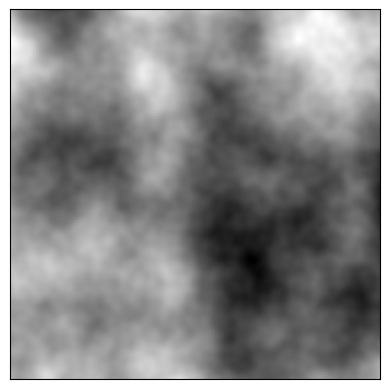

In [8]:
def comb_func(h, z, scale=1):
    '''
    h: the given existing heightmap
    z: the new values to be added to the heightmap
    scale: percentage influence on added values
    '''
    return h+(z*scale)

    '''
    Comment above return statement to change the combination of noise results
    Below method workd by scaling values based on the height of the input heightmap
    meaning the height will increase more at values that are already large.
    This causes the lower elevation areas to remain more flat as well as making peaks more "peaky"
    '''
    
    s = norm_zero(h)
    return h + (((z * s) * scale))
    
#h = norm_zero(make_perlin_heightmap(200, 2, seed=10))

def f1(z):
    return -abs(z)

h = fractal_noise(256, [1, 2, 4, 8, 16, 32], comb_func=comb_func, persistence=1)

# h[:,:100]=norm(h[:, :100], 0, 1)
# h[:,100:]=norm(h[:, 100:], 0, 3)

# h = savgol_filter(h, window_length=10, polyorder=2)

plt.imshow(norm_zero(h), cmap='grey')
plt.xticks([])
plt.yticks([])
#plt.savefig('ridgedFractalExample')
plt.show()

# Different method of fractal noise
This method works by first creating a single instance of ridged perlin noise with the ridge acting like a valley, then other layers added on top are changed to have less of an effect on lower elevation regions causing the original valley to remain throughout.

When viewed with the 3D graph below it creates an effect like islands in an ocean, a few with large mountains

i = 32


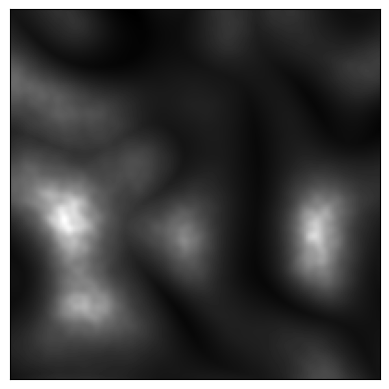

In [11]:
def comb_func2(h, z, scale=100):
    '''
    h: the given existing heightmap
    z: the new values to be added to the heightmap
    scale: percentage influence on added values
    '''
    s = np.power(norm_zero(h), 2)
    z = norm_zero(-np.abs(z))
    return h + (((z * s) * scale / 100))

h = norm_zero(np.power(np.abs(make_perlin_heightmap(200, 3)), 1.25))
add = norm_zero(make_perlin_heightmap(200, 2))
h = (norm_zero((h+add)))
for i in [4, 8, 16, 32]:
    clear_output(wait=True)
    print('i =',i)
    h = comb_func2(h, norm_zero(make_perlin_heightmap(200, i)), scale=100)

# h = comb_func(h, norm_zero(make_perlin_heightmap(200, 10)))

plt.imshow(h, cmap='grey')
plt.xticks([])
plt.yticks([])
plt.show()

# Used for more testing with ridged fractal noise to create better peaks

i = 32


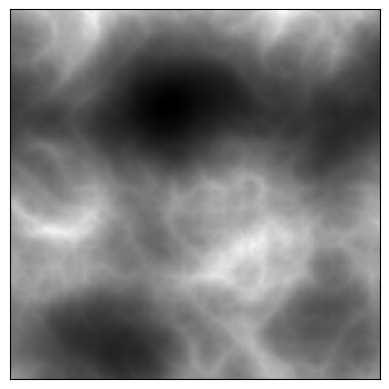

In [14]:
def comb_func3(h, z, scale=100):
    return h+(z*norm_zero(h))

h = make_perlin_heightmap(150, 2, seed=10, x_offset=150)
for i in [4, 8, 16, 32]:
    clear_output(wait=True)
    print('i =',i)
    h = comb_func3(h, -np.abs(make_perlin_heightmap(150, i, seed=10, x_offset=150)))

plt.imshow(h, cmap='grey')
plt.xticks([])
plt.yticks([])
plt.imsave('im2.png', h, cmap='grey')
plt.show()

# Make a shaded version of a heightmap

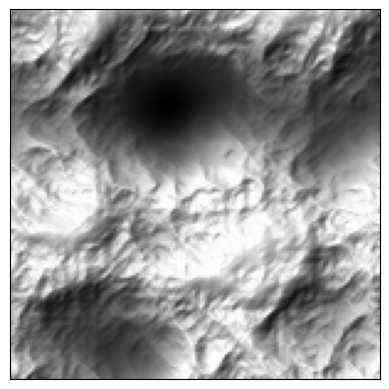

In [15]:
ls = LightSource(azdeg=315, altdeg=45)

h_shaded = ls.shade(h, cmap=plt.cm.gray)

plt.imshow(h_shaded, cmap='grey')
plt.xticks([])
plt.yticks([])
plt.show()

# Use plotly to generate 3D graph of heightmap

In [16]:
# Call function to view heightmap in 3D
import plotly.io as pio

pio.renderers.default = 'browser'

fig = go.Figure(data=[go.Surface(z=norm_zero(h))])

fig.update_layout(scene=dict(zaxis=dict(range=[-0.5,5])))

fig.update_traces(colorscale=["blue", "blue", "teal", "green", "green", "green", "green", "grey", "grey", "white", "white"])

fig.show()

# Example of interpolation

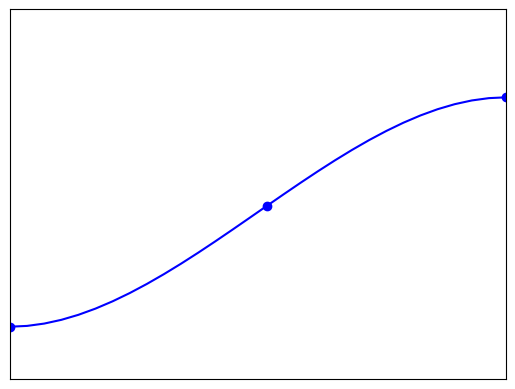

In [38]:
x0 = random.random() * 0.4
x1 = random.random() * 0.5
x1 += 0.5
x0 += 0.1

def interp(x):
    return ((x1 - x0) * x) + x0

def interp(x, x0, x1):
    return x0*(2*(x**3)-3*(x**2)+1) + x1*(-2*(x**3)+3*(x**2)) 

x = np.linspace(0, 1, 30)

y = interp(x, x0, x1)

x2 = random.random()

plt.plot(x,y, '-bo', markevery=[0, 15, 29])
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xticks([])
plt.yticks([])
plt.savefig('CubicInterpolation')
plt.show()